In [1]:
%matplotlib inline

import re

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
mail_df = pd.read_csv('../data/enron-mails-insiders-only.csv', index_col=0)
mail_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  
0       dasovich-j/all_documents/596.  
1      scott-s/discussion_threads/30.  
2      ward-k/discussion_threads/157.  
3  williams-j/discussion_threads/109.  
4        williams-j/all_documents/85.

### Documents cleaning

In [3]:
nlp = spacy.load('en')
STOP_WORDS |= {"to", "cc", "subject", "http", "from", "sent", "pm", "forward"}

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

regexp = re.compile(r'^[a-z]+$')

def clean_text(text):
    text = text.lower()
    doc = nlp(text)
    
    cleaned = []
    for token in doc:
        if not (token.is_punct or token.is_stop or len(token) == 1) and regexp.fullmatch(token.lemma_):
            cleaned.append(token.lemma_)
            
    return cleaned

In [4]:
mail_df['lemmas'] = mail_df.message.map(clean_text)
mail_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  \
0       dasovich-j/all_documents/596.   
1      scott-s/discussion_threads/30.   
2      ward-k/discussion_threads/157.   
3  williams-j/discussion_threads/109.   
4        williams-j/all_documents/85.   

                                              lemmas  
0  [hey, talkin, gas, trash, counsel, susan, jeff...  
1  [have, review, agreement, summary, provision, ...  
2  [get, rfp, border, steel, inc, texas, corporat...  
3  [kim, annex, print, gtc, annex, credit, provis...  
4  [tana, respect, assignment, fletcher, challeng...

#### Top N words after clening

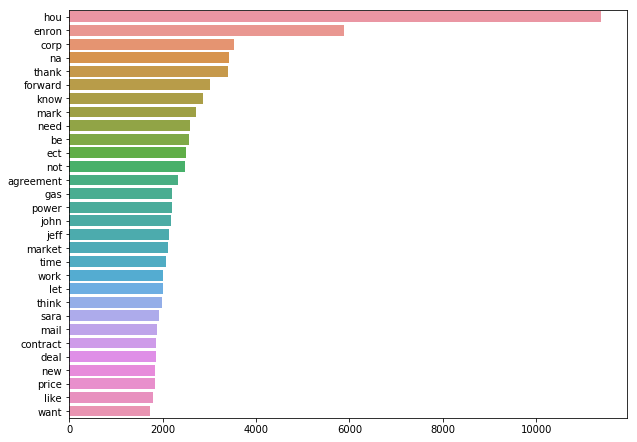

In [5]:
n = 30
top_n_words = pd.Series(np.hstack(mail_df.lemmas)).value_counts()[:n]

plt.figure(figsize=(10, n/4))
sns.barplot(x=top_n_words, y=top_n_words.index)

### Documents embedding

In [6]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(mail_df.lemmas)]

In [7]:
EMBEDDING_SIZE = 100
EPOCHS = 40

model = Doc2Vec(documents, 
                vector_size=EMBEDDING_SIZE,
                min_count=1,
                epochs=EPOCHS,
                workers=4)

### Show similar documents

In [8]:
test_msg_index = 10

line_sep = '='*119

print('Base message:')
print(mail_df.loc[test_msg_index].message)
print(line_sep)

sim = model.docvecs.most_similar(test_msg_index)

for doc_id, similarity in sim[:3]:
    print('Similarity: ', similarity, '\n')
    print(mail_df.loc[doc_id].message)
    print(line_sep)

Base message:
Sally, 

I wanted to thank you for the tickets to Saturday's Astros game.  I took my 2 
year old son and we had a great time.  That was his first game, and he is 
still talking about it.
Similarity:  0.7403167486190796 

Thanks!
Similarity:  0.7295230627059937 

thanks
Similarity:  0.7189488410949707 

Thanks


/home/michal/.conda/envs/tensorflow/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [9]:
data = [model.docvecs[i] for i in mail_df.index]
data[:1]

[array([ 0.8664516 ,  1.6588669 , -0.71161735, -0.9254263 ,  2.9422226 ,
        -0.88547087, -0.8613122 , -0.29975092, -0.44667745,  0.13877682,
        -0.8809153 , -1.6544251 , -0.30449218, -0.34534454,  1.6585538 ,
         0.94403195, -0.52459824,  0.39133215,  1.0281564 , -0.09519657,
         1.2133403 , -0.7430777 ,  0.7897006 ,  0.54602516,  0.01812755,
        -0.5385066 , -2.0454962 , -1.3543707 ,  1.4896101 ,  0.34197325,
         1.1732408 ,  0.88064337,  1.7200087 , -0.54700834, -0.24337171,
         2.177015  , -0.06368247, -0.31896245, -1.2305049 ,  1.7661612 ,
        -0.74755925, -2.1618772 , -0.8103034 ,  1.0014445 ,  0.16926366,
         0.46981093, -0.3775426 ,  0.8923516 ,  0.7183011 ,  0.8030607 ,
        -1.3414669 , -0.5427225 , -0.3932242 ,  0.9780543 , -1.7094212 ,
        -0.3705356 ,  1.7495713 , -0.14203426, -1.0617933 , -0.34906098,
         0.40347967, -0.72279495, -0.33208457, -0.70776314,  1.0432056 ,
         0.8622678 , -0.16689059, -0.7373833 , -0.8

### Visualize embeddings with PCA and TSNE

In [10]:
X_pca = PCA(n_components=2).fit_transform(data)


#### PCA

Text(0.5, 1.0, 'PCA documents')

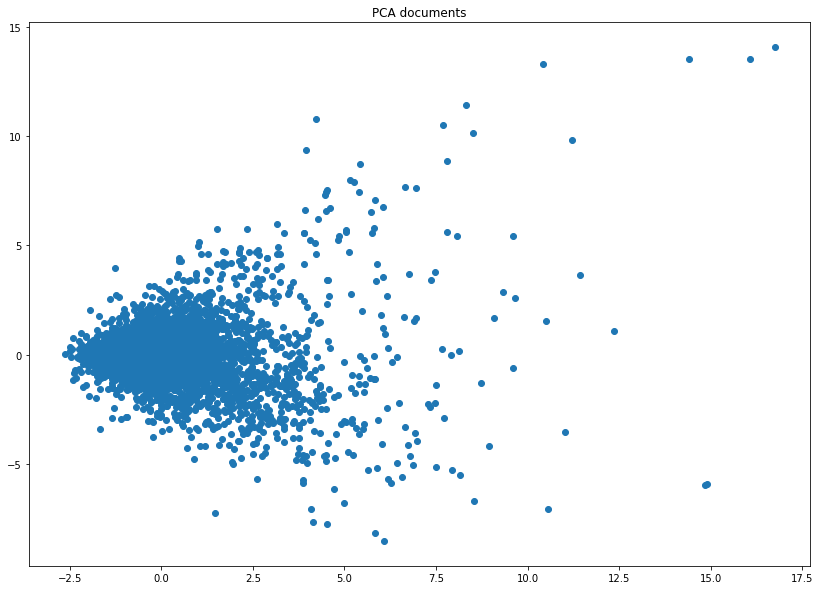

In [11]:
plt.figure(figsize=(14, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA documents')

#### TSNE

In [12]:
X_tsne = TSNE(n_components=2).fit_transform(data)

Text(0.5, 1.0, 'TSNE documents')

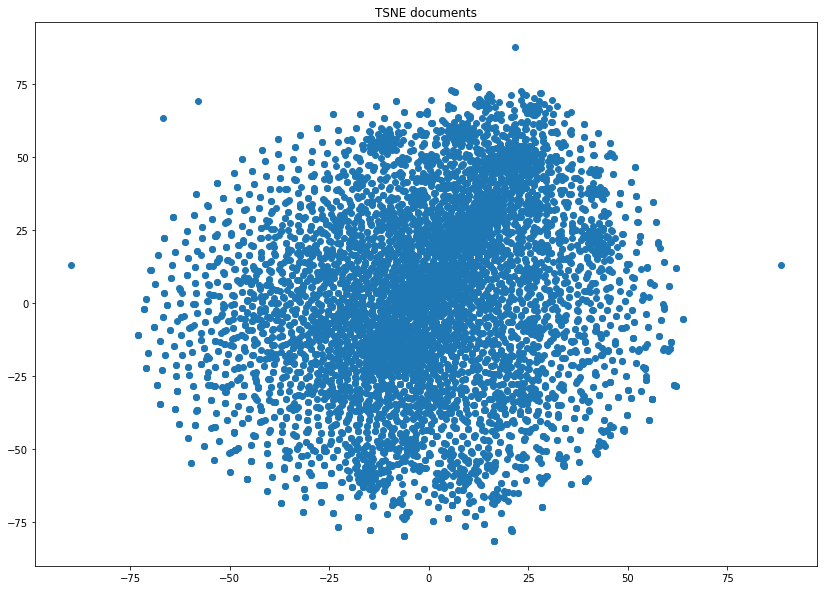

In [13]:
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('TSNE documents')

### Group similar documents

In [14]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

#### Visualize clustering
a) using PCA

Text(0.5, 1.0, 'PCA documents clustering')

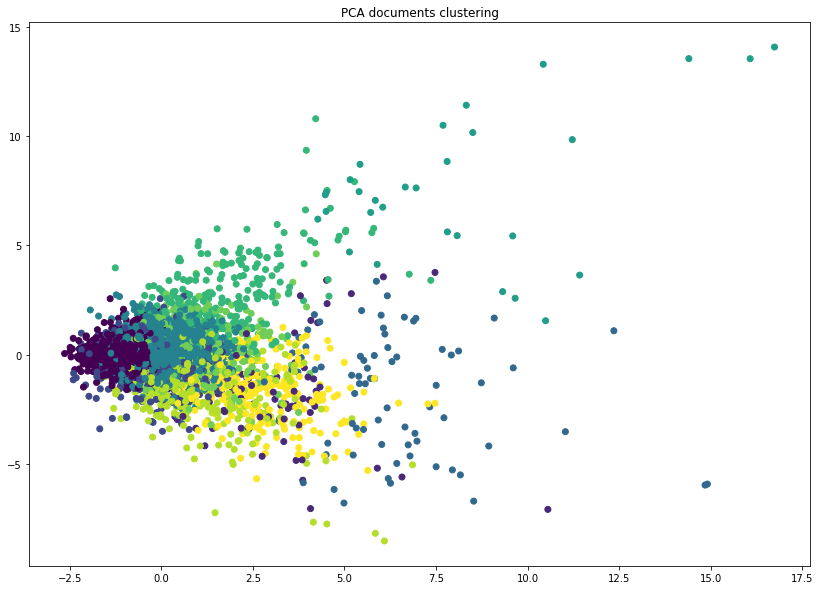

In [15]:
plt.figure(figsize=(14, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.title('PCA documents clustering')

b) using TSNE

Text(0.5, 1.0, 'TSNE documents clustering')

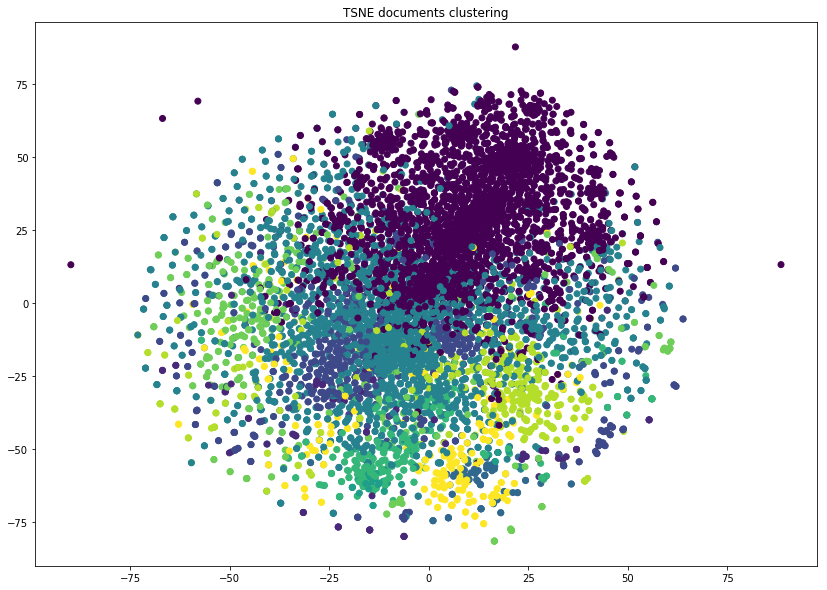

In [16]:
plt.figure(figsize=(14, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_)
plt.title('TSNE documents clustering')

### Save updated dataframe

In [17]:
mail_df['topic'] = kmeans.labels_
mail_df.drop('lemmas', axis=1, inplace=True)
mail_df.head()

date                      from                        to  \
0  1980-01-01 00:00:00   jeff.dasovich@enron.com     susan.scott@enron.com   
1  1980-01-01 00:00:00     susan.scott@enron.com     drew.fossum@enron.com   
2  1980-01-01 00:00:00        kim.ward@enron.com  jason.williams@enron.com   
3  1980-01-01 00:00:00  jason.williams@enron.com        kim.ward@enron.com   
4  1980-01-01 00:00:00  jason.williams@enron.com      tana.jones@enron.com   

                         subject  \
0           Re: Pedersen inquiry   
1     Gallup compressor contract   
2               Re: Border Steel   
3                           GTCs   
4  Re: Fletcher Challenge/Apache   

                                             message  \
0  Hey, you be talkin' to gas trash, counsel.\n\n...   
1  I've reviewed the O&M Agreement and here is a ...   
2  J.-\n\nJust got an RFP from Border Steel, Inc....   
3  Kim -\n\nAnnex A are the printed GTC\n\nAnnex ...   
4  Tana -\n\nWith respect to assignment of the Fl...   

                                 file  topic  
0       dasovich-j/all_documents/596.      8  
1      scott-s/discussion_threads/30.      8  
2      ward-k/discussion_threads/157.      0  
3  williams-j/discussion_threads/109.      4  
4        williams-j/all_documents/85.      2

In [18]:
mail_df.to_csv('../data/enron-mails-with-topic.csv')